# The Bitcoin Lower Bound
## How to calculate the seignorage price of Bitcoin
___
## Introduction
**Abstract:**  
Predicting the price of Bitcoin has become an art and a science to many. Individuals often take to fundamental and technical analysis to analyze the state of the market and determine a price of Bitcoin. I've come to notice, however, that Bitcoin has a price found at the equilibrium between the block reward supply and the aggregate demand for said Bitcoins displayed by the network's miners. I call this price the *seignorage price* and its rate of return over time the *seignorage rate*. In this notebook, we'll explore how this price is found and how accurate it could be. 

**Background:**  
As more traditional financial institutions enter into the nascent class of digital assets, the need to formalize quantitative measures of pricing and risk increases. While existing models applied to equities and derivatives such as the [Capital Asset Pricing Model](https://www.investopedia.com/terms/c/capm.asp) and [Black-Scholes Model](https://www.investopedia.com/terms/b/blackscholes.asp) may be loosely applied to digital assets, it's important that these models become adapted to this new class or have analogues that are native to the assets. This pricing model can serve as the foundation ontop of which subsequent quantitative methods can build.

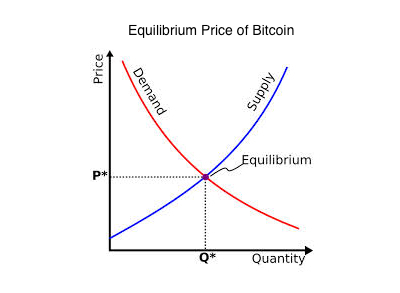

In [59]:
from IPython.display import Image
Image(filename='/Users/aunyks/dev/riskless-crypto-asset/theoretical-supply-demand.jpg', embed=True)

**Why it's a true price:**  
This model relies on the good faith that the global average cost of power will gradually decrease or stay at a constant price, so that miners will always have a net positive [seignorage](https://en.wikipedia.org/wiki/Seigniorage) when producing Bitcoin.
___
## Getting the Data
To derive this model, we'll need several data sources: the network hashrate of Bitcoin over a course of time, the price of Bitcoin over a course of time, the global average amount of power used per hash, the global average cost of power consumption, and the current circulating supply of Bitcoin.  

The hashrate over time and price over time are easy to find, as they can be located at [blockchain.com](https://blockchain.com) along with the supply data that we'll use for later. To grab those data, simply `curl` the JSON into a local directory.
```bash
> curl https://api.blockchain.info/charts/hash-rate\?timespan\=all\&format\=json -o btc-hashrate.json

> curl https://api.blockchain.info/charts/market-price\?timespan\=all\&format\=json -o btc-price.json

> curl https://api.blockchain.info/charts/miners-revenue\?timespan\=all\&format\=json -o btc-revenue.json

> curl https://api.blockchain.info/charts/total-bitcoins\?timespan\=all\&format\=json -o btc-supply.json

> curl https://api.blockchain.info/charts/transaction-fees-usd\?format\=json -o btc-txion-fees.json
```
The global average amount of power used per hash and cost of power consumption are harder to find, however. The average cost of power can be found from for a short list of countries at [statista.com](https://www.statista.com/) and can be used to create a rough estimate of the average cost around the world. Those data are as follow.

[Global electricity prices by select countries in 2017 (in U.S. dollars per kilowatt hour)](https://www.statista.com/statistics/263492/electricity-prices-in-selected-countries/)

In [60]:

from sklearn import linear_model
import numpy
import matplotlib.pyplot as plt
import json
import csv
import datetime

# Change these for your machine
HASHRATE_FILEPATH = '/Users/aunyks/dev/riskless-crypto-asset/btc-hashrate.json'
CONSUMPTION_FILEPATH = '/Users/aunyks/dev/riskless-crypto-asset/beci.csv'
PRICE_FILEPATH = '/Users/aunyks/dev/riskless-crypto-asset/btc-price.json'
SUPPLY_FILEPATH = '/Users/aunyks/dev/riskless-crypto-asset/btc-supply.json'
REVENUE_FILEPATH = '/Users/aunyks/dev/riskless-crypto-asset/btc-revenue.json'
AVG_HASHRATE = 10 * 10e12
NUM_NODES = 9877

def fit_linear(x, y):
    model = linear_model.LinearRegression(fit_intercept=True)
    model.fit(numpy.array(x).reshape(-1, 1), numpy.array(y).reshape(-1, 1))
    def model_prediction(x):
        return model.predict(x)[0][0]
    return model_prediction

def fit_poly(x, y):
    return numpy.poly1d(numpy.polyfit(x, y, 3))

def find_nearest(array, value):
    array = numpy.asarray(array)
    idx = (numpy.abs(array - value)).argmin()
    return array[idx]

def btc_supply(era):
    numerator = 0
    for j in range(0, era):
        numerator = numerator + (210000 * ((50 * 10e8) / 2**j))
    return numerator / 10e8

def reward_at_era(era):
    return (btc_supply(era) - btc_supply(era - 1)) / 210000

def era_at_millis(ms):
    genesis_date_in_millis = 1231024505000
    block_per_era = 210000
    minutes_bw_blocks = 10
    millis_per_minute = 60000
    millis_bw_blocks = minutes_bw_blocks * millis_per_minute
    millis_per_era = millis_bw_blocks * block_per_era
    return (ms - genesis_date_in_millis) / millis_per_era + 1

def reward_at_millis(ms):
    return reward_at_era(era_at_millis(ms))

%matplotlib inline

In [61]:
# Price (USD) of one KWh in countries
price_kwh =  {
  'germany': 0.33,
  'italy': 0.29,  
  'belgium': 0.26,  
  'spain': 0.26, 
  'portugal': 0.25,
  'uk': 0.24,
  'sweden': 0.22,
  'austria': 0.22,
  'us': 0.21,
  'france': 0.20,
  'netherlands': 0.20, 
  'slovakia': 0.18,
  'finland': 0.18,
  'poland': 0.17,
  'canada': 0.16,
  'czech_republic': 0.15,
  'brazil': 0.14,
  'china': 0.09,
  'south_africa': 0.09,
  'india': 0.08
}

In [62]:
average_price_power = numpy.mean(price_kwh.values())
print 'Average price per kilowatt-hour in USD: %.3f $/KWh' % average_price_power

Average price per kilowatt-hour in USD: 0.196 $/KWh


The amount of power used per hash can be computed by dividing the total amount of power consumed by the network by the network hashrate. We already have the network hashrate, and we can get the total amount of power consumed by the network from the [Bitcoin Energy Consumption Index (BECI)](https://digiconomist.net/bitcoin-energy-consumption). Those data are as follow.

In [63]:
hashrate = {}
consumption = {}
price = {}
supply = {}
revenue = {}

with open(HASHRATE_FILEPATH, 'r') as f:
    hashrate = json.load(f)

with open(PRICE_FILEPATH, 'r') as f:
    price = json.load(f)

with open(SUPPLY_FILEPATH, 'r') as f:
    supply = json.load(f)

with open(REVENUE_FILEPATH, 'r') as f:
    revenue = json.load(f)

with open(CONSUMPTION_FILEPATH, 'r') as f:
    reader = csv.reader(f)
    next(reader, None)
    for k, v in reader:
        date = datetime.datetime.strptime(k, '%Y/%m/%d')
        date_millis_since_epoch = int(date.strftime('%s')) * 1000
        consumption[date_millis_since_epoch] = float(v)

For whatever reason, the price, hashrate, fee, and circulating supply time data are denominated in seconds. Let's convert them to milliseconds in order to maintain dimensional equivalence with the consumption time data.

In [64]:
for datum in price['values']:
    datum['x'] = datum['x'] * 1000

for datum in hashrate['values']:
    datum['x'] = datum['x'] * 1000

for datum in supply['values']:
    datum['x'] = datum['x'] * 1000
    
for datum in revenue['values']:
    datum['x'] = datum['x'] * 1000

Because the BECI data have the least range among all of our time series data, we'll get rid of all data that are out of its range.

In [65]:
first_data_point = numpy.nanmin(consumption.keys())
i = 0
while price['values'][i]['x'] < first_data_point:
    copy = list(price['values'])
    del copy[i]
    price['values'] = copy

while hashrate['values'][i]['x'] < first_data_point:
    copy = list(hashrate['values'])
    del copy[i]
    hashrate['values'] = copy

while supply['values'][i]['x'] < first_data_point:
    copy = list(supply['values'])
    del copy[i]
    supply['values'] = copy

while revenue['values'][i]['x'] < first_data_point:
    copy = list(revenue['values'])
    del copy[i]
    revenue['values'] = copy

Let's reshape our price, hashrate, and supply data for ease of plotting and computation.

In [66]:
# [{'x', 10000, 'y': 1.5}] => {10000: 1.5}
normal_hashrate = {}
normal_price = {}
normal_supply = {}
normal_revenue = {}

for rate in hashrate['values']:
    normal_hashrate[rate['x']] = rate['y']
hashrate = fit_linear(normal_hashrate.keys(), normal_hashrate.values())

for rate in price['values']:
    normal_price[rate['x']] = rate['y']

for rate in supply['values']:
    normal_supply[rate['x']] = rate['y']
supply = fit_linear(normal_supply.keys(), normal_supply.values())

for rate in revenue['values']:
    normal_revenue[rate['x']] = rate['y']
revenue = fit_linear(normal_revenue.keys(), normal_revenue.values())

Now that our data are normalized, let's calculate the power per hash.

In [67]:
# Consumption = TWh / year, Hashrate = TH / s
# Power per hash = (TWh / year) / (TH / s) = (TWh / year) * (s / TH) * (31536000 / 1)
# Power per hash = (TWh / TH) * (10e12 / 10e9)
# Power per hash = (KWh / H)
pph = {}
for time in consumption.keys():
    nearest_hashrate_time = find_nearest(normal_hashrate.keys(), time)
    pph[time] = consumption[time] / normal_hashrate[nearest_hashrate_time]
    pph[time] = pph[time] * 31536000
    pph[time] = pph[time] * (10e12 / 10e9)

Now that we have the power per hash, let's find out how much miners are paying in aggregate per hash.

In [68]:
usd_per_hash = {}
for time in pph.keys():
    usd_per_hash[time] = pph[time] * average_price_power

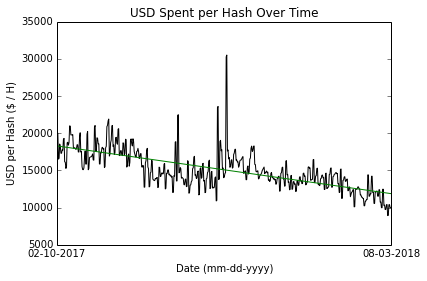

In [69]:
x = list(usd_per_hash.keys())
x.sort()
y = [usd_per_hash[time] for time in x]
usdph = fit_linear(x, y)
plt.title('USD Spent per Hash Over Time')
plt.xlabel('Date (mm-dd-yyyy)')
plt.ylabel('USD per Hash ($ / H)')
plt.xticks([x[0], x[len(x) - 1]], \
           [datetime.datetime.fromtimestamp(x[0] / 1000).strftime('%m-%d-%Y'), datetime.datetime.fromtimestamp(x[len(x) - 1] / 1000).strftime('%m-%d-%Y')])
plt.plot(x, y, 'k-')
plt.plot(x, [usdph(time) for time in x], 'g-')
plt.show()

Miners are spending less over time to mine (or "get") Bitcoin, which means that demand is naturally decreasing as they're "bidding" less for Bitcoin over time, albeit involuntarily as it's the increase in mining efficiency that causes this decrease. But, that's one half of this pricing model. The other half is the supply.  

The good thing, though, is that Bitcoin's supply is predictable at any point in time.

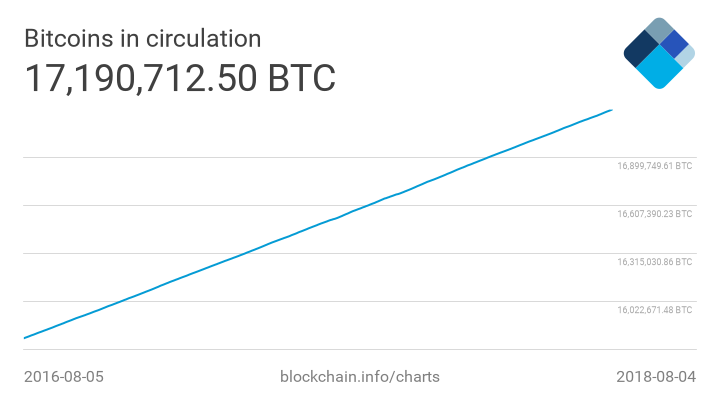

In [70]:
from IPython.display import Image
Image(filename='/Users/aunyks/dev/riskless-crypto-asset/btc-block-supply.png', embed=True)

Now that we have our supply data in the form of block reward in USD and demand data in the form of price that Bitcoin miners pay to mine, we can look at a supply / demand chart and get our price from there.

In [71]:
demand_curve = {}
supply_curve = {}
def supply_fn(x):
    return revenue(x) / 21*10e7
    
def demand_fn(x):
    return usdph(x) * hashrate(x) / 21*10e7
    
for time in usd_per_hash.keys():
    qty_at_time = supply(time)
    demand_curve[qty_at_time] = demand_fn(time)
    supply_curve[qty_at_time] = supply_fn(time)

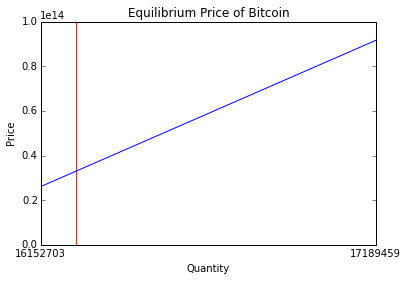

Seignorage Price of Bitcoin: $-126,882,312.93
-433466616.317


In [77]:
quantity = list(demand_curve.keys())
quantity.sort()
demand_curve_actual = [demand_curve[qty] for qty in quantity]
supply_curve_actual = [supply_curve[qty] for qty in quantity]
plt.title('Equilibrium Price of Bitcoin')
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.ylim([0, 10e13])
plt.xticks([quantity[0], quantity[-1]], [int(quantity[0]), int(quantity[-1])])
plt.plot(quantity, demand_curve_actual, 'r-')
plt.plot(quantity, supply_curve_actual, 'b-')
plt.show()
print 'Seignorage Price of Bitcoin: ${:,.2f}'.format(supply_fn(quantity[60]) / quantity[60])
print revenue(quantity[60])

## Wrapping Up
There we have it! After plotting the aggregate supply of Bitcoin (actual price of Bitcoin wrt circulating supply) and the aggregate demand of Bitcoin (USD spent per hash wrt circulating supply), we've calculated an estimate of the *seignorage price* or equilibrium price of Bitcoin during mining.  

Because this is an equilibrium price, any price above it means that Bitcoin is theoretically overvalued and any price below it theoretically undervalues the currency.  

I speculate that this price acts as a lower bound for the actual price of Bitcoin, however, as it only accounts for the economics of mining Bitcoin and neglects Bitcoin's utility or any speculation that cryptocurrency markets posess.

## Knobs and Switches
And this $11k price tag isn't set in stone. There are many components of this derivation that are, themselves, erroneous to some degree and could account for any inaccuracy in this calculation. Specifically, the global average cost per KWh in this notebook accounted for a few countries far from the entire world, the amount of power consumed by the Bitcoin miners is an estimation performed by [Digiconomist](https://digiconomist.net), and the regression model used to predict the supply and demand curves could be tweaked to give different results.